In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", shuffle = True, image_size = (IMAGE_SIZE,IMAGE_SIZE), batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 2 0 0 1 1 1 0 0 1 1 0 0 1 0]


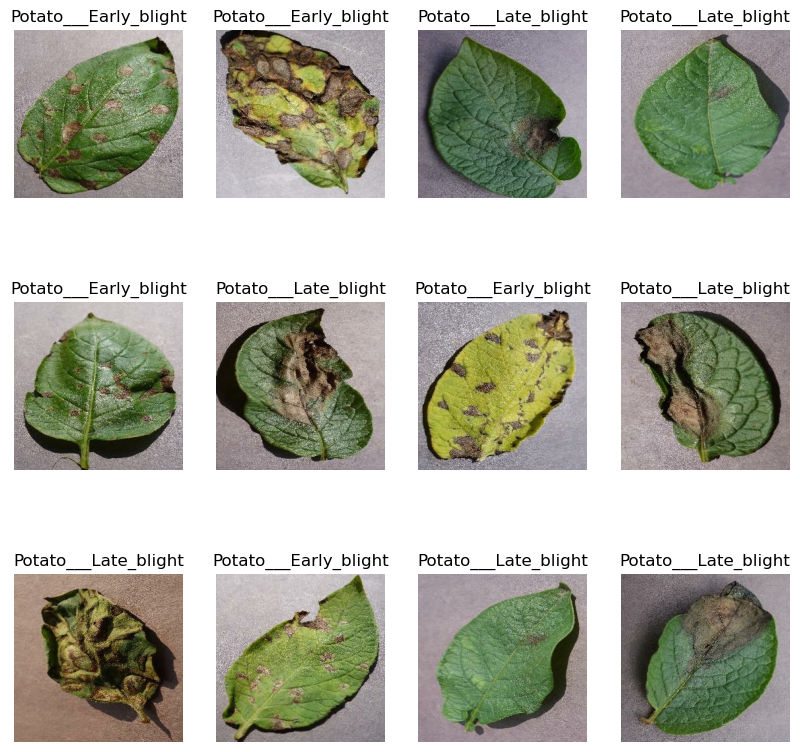

In [5]:
plt.figure(figsize = (10,10))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    assert(train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
len(train_ds)

54

In [9]:
len(test_ds)

8

In [10]:
len(val_ds)

6

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale, data_augmentation, layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), 
        layers.MaxPooling2D((2,2)), 
        layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation = 'relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation = 'relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation = 'relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(n_classes, activation = 'softmax')
    ])
model.build(input_shape= input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [16]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [17]:
history = model.fit(
    train_ds, batch_size = BATCH_SIZE,
    validation_data = val_ds, verbose = 1,
    epochs = EPOCHS
)

Epoch 1/50
54/54 [==============================] - 70s 1s/step - loss: 0.9130 - accuracy: 0.5133 - val_loss: 0.9677 - val_accuracy: 0.4115
Epoch 2/50
54/54 [==============================] - 65s 1s/step - loss: 0.8648 - accuracy: 0.5521 - val_loss: 0.6938 - val_accuracy: 0.7656
Epoch 3/50
54/54 [==============================] - 65s 1s/step - loss: 0.5894 - accuracy: 0.7529 - val_loss: 0.4846 - val_accuracy: 0.7917
Epoch 4/50
54/54 [==============================] - 65s 1s/step - loss: 0.4301 - accuracy: 0.8148 - val_loss: 0.4830 - val_accuracy: 0.8333
Epoch 5/50
54/54 [==============================] - 65s 1s/step - loss: 0.3167 - accuracy: 0.8762 - val_loss: 0.5096 - val_accuracy: 0.8229
Epoch 6/50
54/54 [==============================] - 65s 1s/step - loss: 0.2671 - accuracy: 0.8941 - val_loss: 0.2101 - val_accuracy: 0.9115
Epoch 7/50
54/54 [==============================] - 64s 1s/step - loss: 0.2244 - accuracy: 0.9161 - val_loss: 0.4985 - val_accuracy: 0.7708
Epoch 8/50
54/54 [==

In [18]:
score = model.evaluate(test_ds)

8/8 [==============================] - 4s 289ms/step - loss: 0.0465 - accuracy: 0.9844


In [20]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
len(history.history['loss'])

50

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


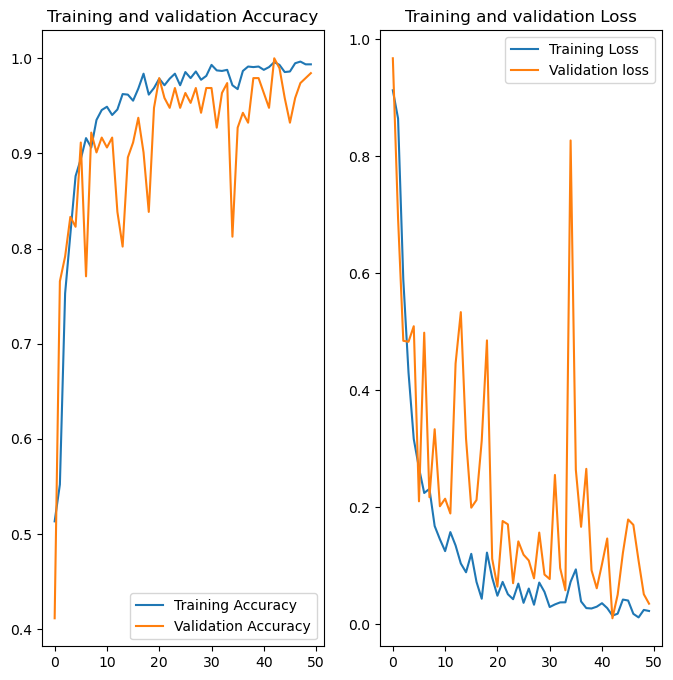

In [27]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training and validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation loss")
plt.legend(loc = 'upper right')
plt.title("Training and validation Loss")
plt.show()

First image to predict
Actual Label: Potato___Early_blight
1/1 [==============================] - 0s 326ms/step
Predicted Label: Potato___Early_blight


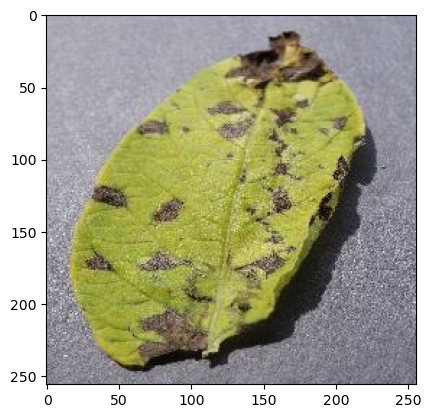

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[labels_batch[0].numpy()])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


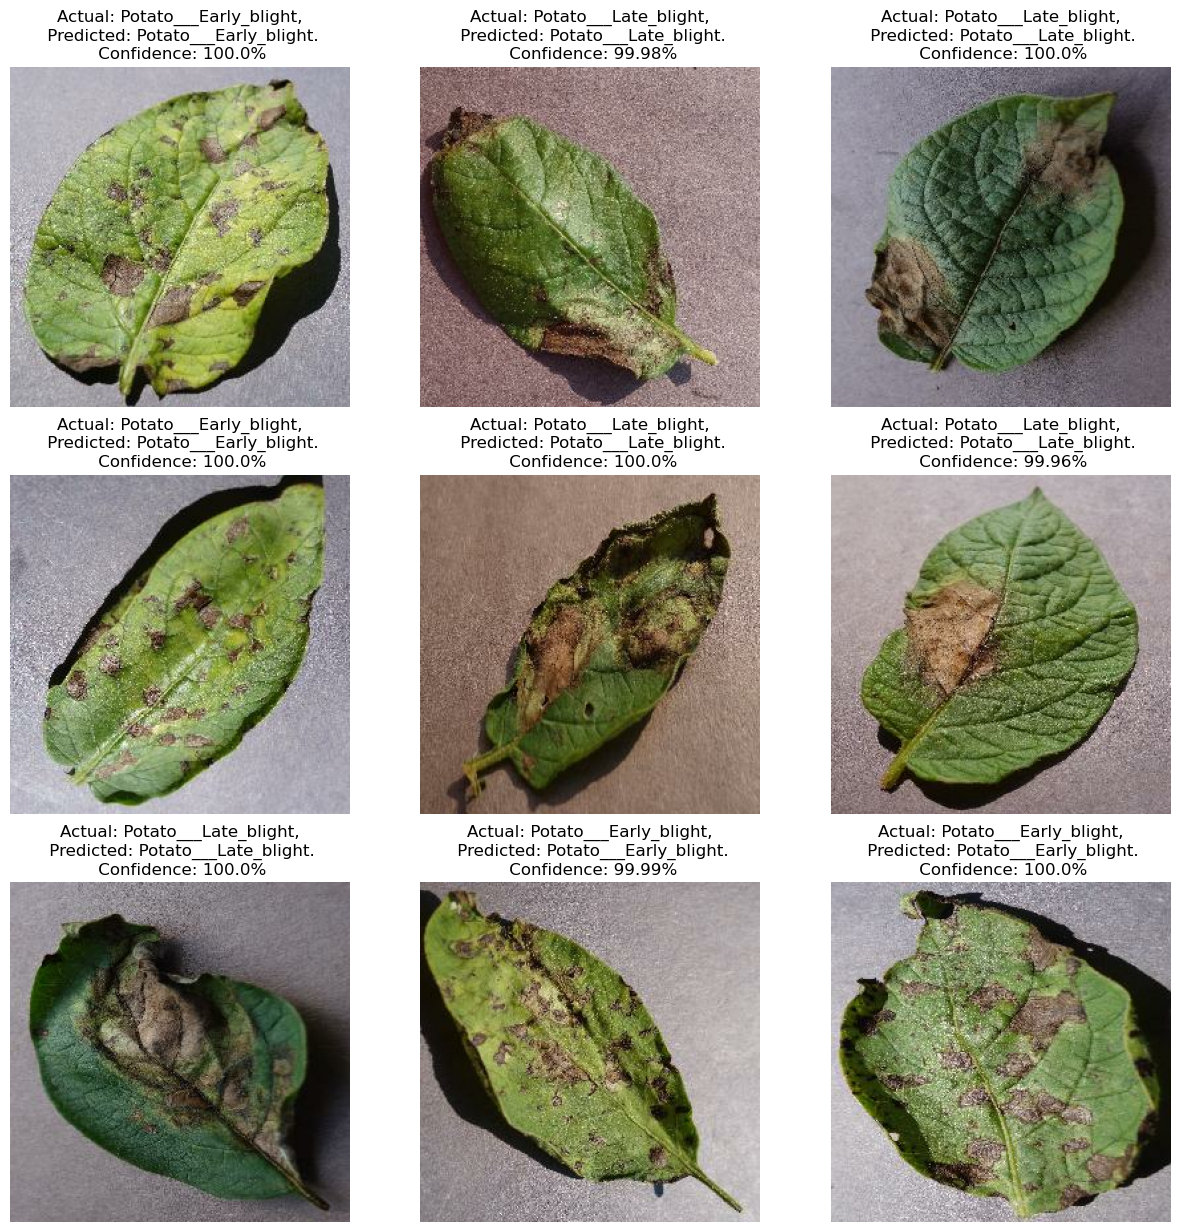

In [41]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%" )
        plt.axis("off")

In [42]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
